### Breast Cancer Detection using EfficientNet| Dataset used - CBIS-DDSM

# Importação de Bibliotecas

In [1]:
pip install matplotlib seaborn plotly pandas pillow opencv-python scikit-learn tensorflow keras

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import warnings
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

SEED_setada = 42
random.seed(SEED_setada)
np.random.seed(SEED_setada)
tf.random.set_seed(SEED_setada)
os.environ["PYTHONHASHSEED"] = str(SEED_setada)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

warnings.filterwarnings("ignore")

c:\Users\Alexandre\Desktop\vscode\FIAP\Tech_challenge_extra\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


#  Aquisição de dados

Lê os dados dos CSV de treino e teste, tanto do conjunto de mass quanto de calc.
Lê os dados de mass_case_description_train_set.csv, mass_case_description_test_set.csv, calc_case_description_train_set.csv e calc_case_description_test_set.csv

In [3]:
mass_train_data = pd.read_csv('data_CBIS_DDSM/csv/mass_case_description_train_set.csv')
print("mass_train_data.head():")
mass_train_data.head()

mass_train_data.head():


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [4]:
mass_test_data = pd.read_csv('data_CBIS_DDSM/csv/mass_case_description_test_set.csv')
print("\nmass_test_data.head():")
mass_test_data.head()


mass_test_data.head():


,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [5]:
calc_train_data = pd.read_csv('data_CBIS_DDSM/csv/calc_case_description_train_set.csv')
print("\ncalc_train_data.head():")
calc_train_data.head()


calc_train_data.head():


,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [6]:
calc_test_data = pd.read_csv('data_CBIS_DDSM/csv/calc_case_description_test_set.csv')
print("\ncalc_test_data.head():")
calc_test_data.head()


calc_test_data.head():


,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...


# Limpeza dos dados

Serão processadas apenas as imagens, portanto, os dados de breast_density, lef or right breast, image view, etc não são relevantes neste contexto. Os dados relevantes são: pathology (nosso alvo), cropped image file path (imagem com a área de interesse já recortada).

In [7]:
# check unique values in pathology column
mass_train_data.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [8]:
calc_train_data.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [9]:
mass_train_data.info()
# check for null values
mass_train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  4
mass margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [10]:
mass_test_data.info()
mass_test_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               378 non-null    object
 1   breast_density           378 non-null    int64 
 2   left or right breast     378 non-null    object
 3   image view               378 non-null    object
 4   abnormality id           378 non-null    int64 
 5   abnormality type         378 non-null    object
 6   mass shape               378 non-null    object
 7   mass margins             361 non-null    object
 8   assessment               378 non-null    int64 
 9   pathology                378 non-null    object
 10  subtlety                 378 non-null    int64 
 11  image file path          378 non-null    object
 12  cropped image file path  378 non-null    object
 13  ROI mask file path       378 non-null    object
dtypes: int64(4), object(10)
memory usage: 41.5

patient_id                  0
breast_density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
mass shape                  0
mass margins               17
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [11]:
calc_train_data.info()
calc_train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1546 non-null   object
 1   breast density           1546 non-null   int64 
 2   left or right breast     1546 non-null   object
 3   image view               1546 non-null   object
 4   abnormality id           1546 non-null   int64 
 5   abnormality type         1546 non-null   object
 6   calc type                1526 non-null   object
 7   calc distribution        1170 non-null   object
 8   assessment               1546 non-null   int64 
 9   pathology                1546 non-null   object
 10  subtlety                 1546 non-null   int64 
 11  image file path          1546 non-null   object
 12  cropped image file path  1546 non-null   object
 13  ROI mask file path       1546 non-null   object
dtypes: int64(4), object(10)
memory usage: 16

patient_id                   0
breast density               0
left or right breast         0
image view                   0
abnormality id               0
abnormality type             0
calc type                   20
calc distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [12]:
calc_test_data.info()
calc_test_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               326 non-null    object
 1   breast density           326 non-null    int64 
 2   left or right breast     326 non-null    object
 3   image view               326 non-null    object
 4   abnormality id           326 non-null    int64 
 5   abnormality type         326 non-null    object
 6   calc type                322 non-null    object
 7   calc distribution        263 non-null    object
 8   assessment               326 non-null    int64 
 9   pathology                326 non-null    object
 10  subtlety                 326 non-null    int64 
 11  image file path          326 non-null    object
 12  cropped image file path  326 non-null    object
 13  ROI mask file path       326 non-null    object
dtypes: int64(4), object(10)
memory usage: 35.8

patient_id                  0
breast density              0
left or right breast        0
image view                  0
abnormality id              0
abnormality type            0
calc type                   4
calc distribution          63
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

## Corrige o caminho das imagens

Caso o arquivo da imagem recortada (cropped image) não seja encontrado, a entrada será excluída.

In [13]:
dicom_data = pd.read_csv('data_CBIS_DDSM/csv/dicom_info.csv')

image_dir = 'data_CBIS_DDSM/jpeg'
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
roi_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path

full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
roi_mask_images = roi_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.iloc[0]

full_mammogram_dict = dict()
cropped_dict = dict()
roi_mask_dict = dict()

for dicom in full_mammogram_images:
    # print(dicom)
    key = dicom.split("/")[2]
    # print(key)
    full_mammogram_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[2]
    cropped_dict[key] = dicom
for dicom in roi_mask_images:
    key = dicom.split("/")[2]
    roi_mask_dict[key] = dicom

def fix_image_path(dataset):
    cropped_errors = []  # aqui vamos guardar as linhas com erro

    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammogram_dict:
            dataset.iloc[i, 11] = full_mammogram_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_dict:
            dataset.iloc[i, 12] = cropped_dict[img_name]
        else:
            cropped_errors.append((i, dataset.iloc[i].copy()))
        
        img_name = img[13].split("/")[2]
        if img_name in roi_mask_dict:
            dataset.iloc[i, 13] = roi_mask_dict[img_name]

    return cropped_errors

In [14]:
cropped_errors = fix_image_path(mass_train_data)
print(len(cropped_errors))
error_indices = [idx for idx, _ in cropped_errors]
mass_train_data = mass_train_data.drop(index=error_indices).reset_index(drop=True)

cropped_errors = fix_image_path(mass_test_data)
print(len(cropped_errors))
error_indices = [idx for idx, _ in cropped_errors]
mass_test_data = mass_test_data.drop(index=error_indices).reset_index(drop=True)

cropped_errors = fix_image_path(calc_train_data)
print(len(cropped_errors))
error_indices = [idx for idx, _ in cropped_errors]
calc_train_data = calc_train_data.drop(index=error_indices).reset_index(drop=True)

cropped_errors = fix_image_path(calc_test_data)
print(len(cropped_errors))
error_indices = [idx for idx, _ in cropped_errors]
calc_test_data = calc_test_data.drop(index=error_indices).reset_index(drop=True)

0
0
2
0


In [15]:
mass_train_data.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...


In [16]:
mass_test_data.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.8...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...


In [17]:
calc_train_data.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.9...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...


In [18]:
calc_test_data.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.4...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.2...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.3...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...


# Análise dos dados

Apenas será analisado a coluna 'pathology', pois a análise é baseada apenas na imagem e neste alvo.

In [19]:
# check datasets shape
print(f'Shape of mass_train: {mass_train_data.shape}')
print(f'Shape of mass_test: {mass_test_data.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [20]:
# check datasets shape
print(f'Shape of calc_train: {calc_train_data.shape}')
print(f'Shape of calc_test: {calc_test_data.shape}')

Shape of calc_train: (1544, 14)
Shape of calc_test: (326, 14)


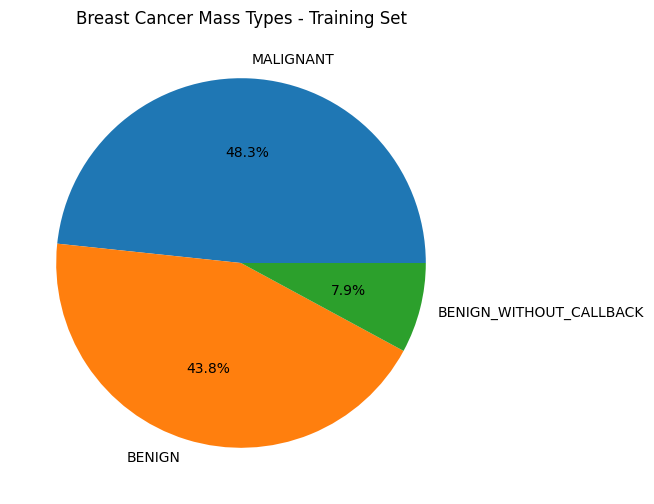

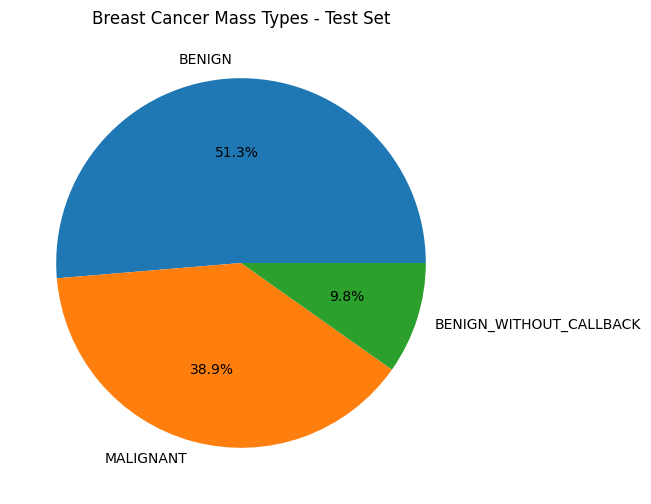

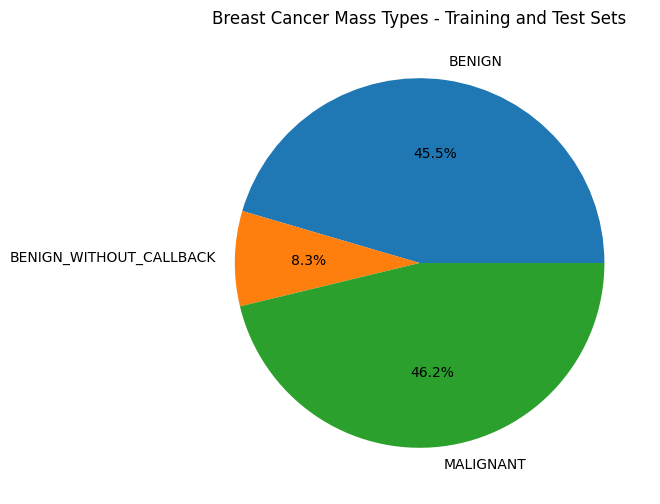

In [21]:
# Distribuição da patologia no mass no conjunto de treino, teste e na soma
value = mass_train_data['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types - Training Set', fontsize=12)
plt.show()

value = mass_test_data['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types - Test Set', fontsize=12)
plt.show()

value = mass_train_data['pathology'].value_counts() + mass_test_data['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types - Training and Test Sets', fontsize=12)
plt.show()

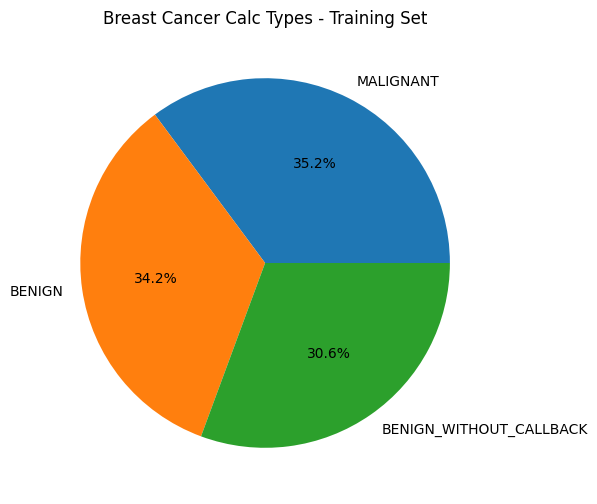

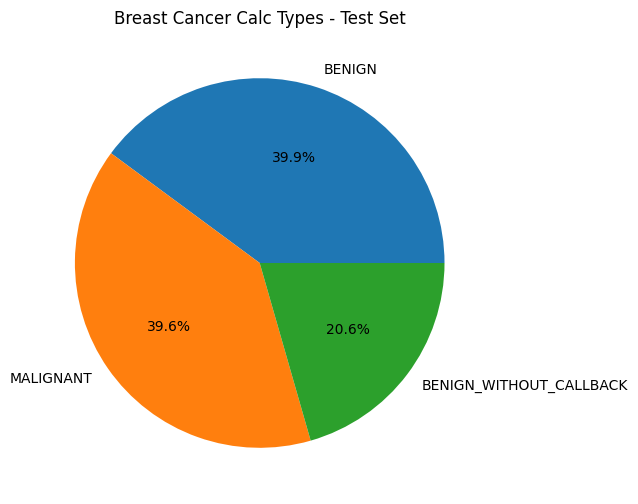

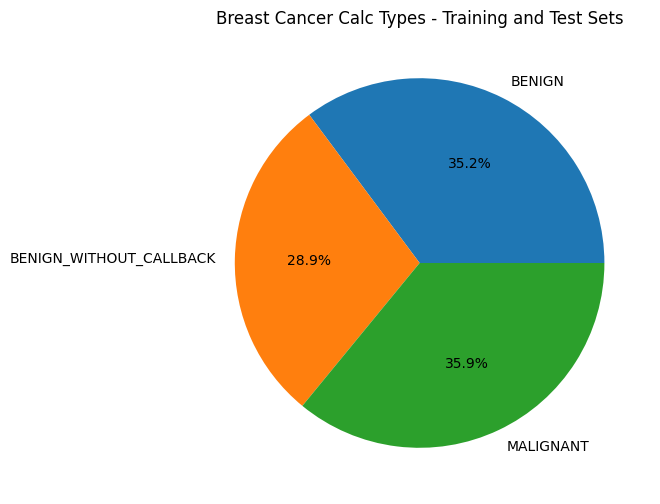

In [22]:
# Distribuição da patologia no calc no conjunto de treino, teste e na soma
value = calc_train_data['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Calc Types - Training Set', fontsize=12)
plt.show()

value = calc_test_data['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Calc Types - Test Set', fontsize=12)
plt.show()

value = calc_train_data['pathology'].value_counts() + calc_test_data['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Calc Types - Training and Test Sets', fontsize=12)
plt.show()

In [23]:
def display_images(column, number, dataset):
    """displays images in the dataset"""

    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

    # Loop through all rows and display images
    for index, row in dataset.head(number_to_visualize).iterrows():
        image_path = row[column]
        print(image_path)
        # Check if the file exists
        if os.path.exists(image_path):
            image = mpimg.imread(image_path)
            ax = axes[index]
            ax.imshow(image, cmap='gray')
            ax.set_title(f"{row['pathology']}")
            ax.axis('off')
        else:
            print(f"File not found: {image_path}")

    plt.tight_layout()
    plt.show()

Mass Training Dataset


Full Mammograms:

data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-250.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-067.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524754913057908920631336070876889890/1-056.jpg


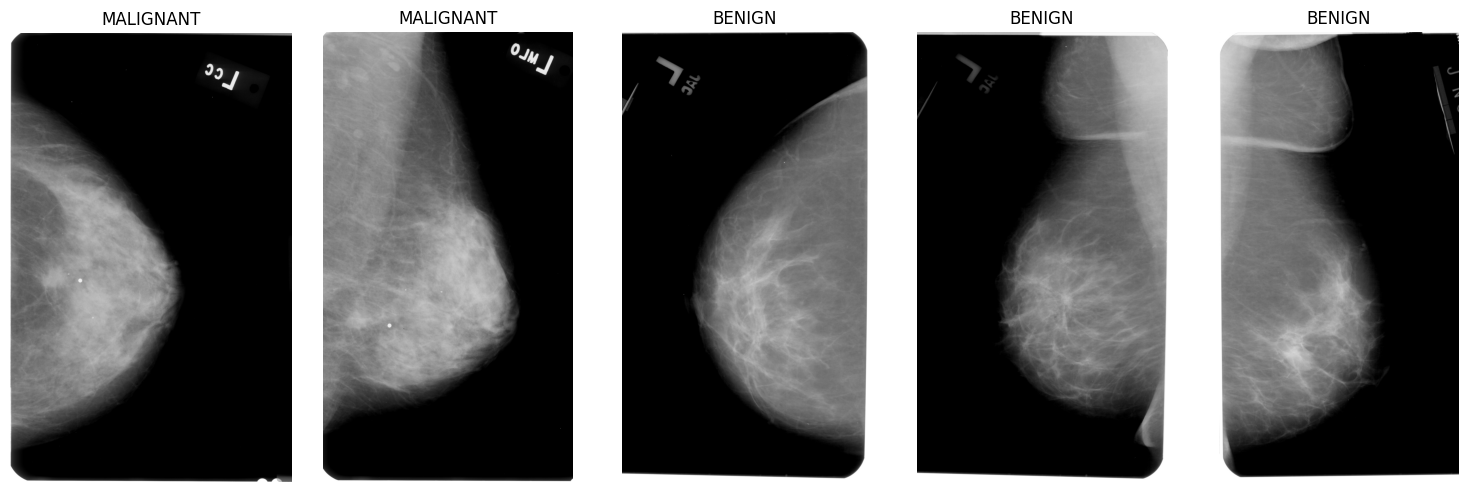

Cropped Mammograms:

data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/2-249.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/2-295.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/2-244.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/1-182.jpg


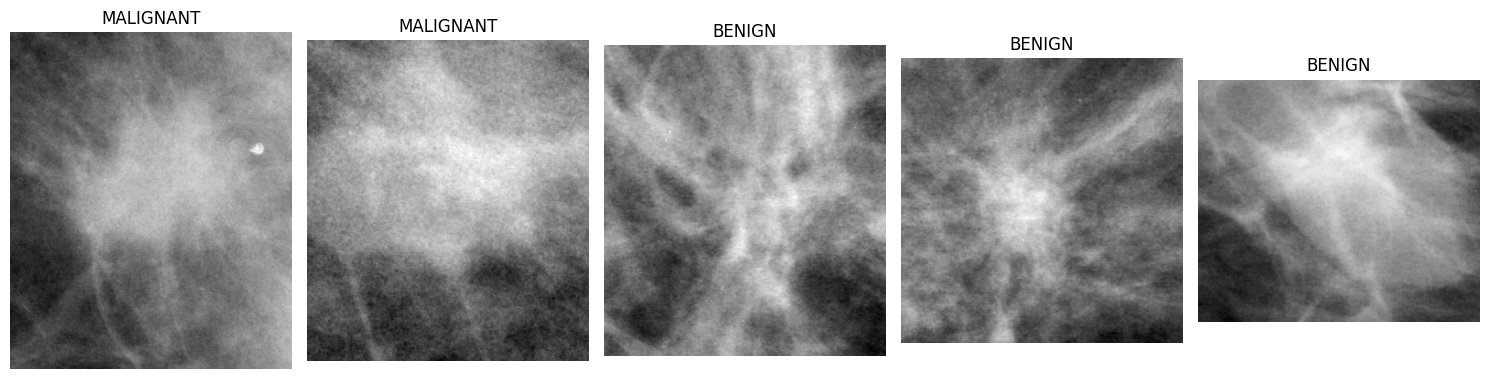

ROI Images:

data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-250.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/2-288.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.429120414011832984817094399141838850375/1-296.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.115134232113001553100559896703407510515/1-245.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.12857366312625701203276284233604184846/2-183.jpg


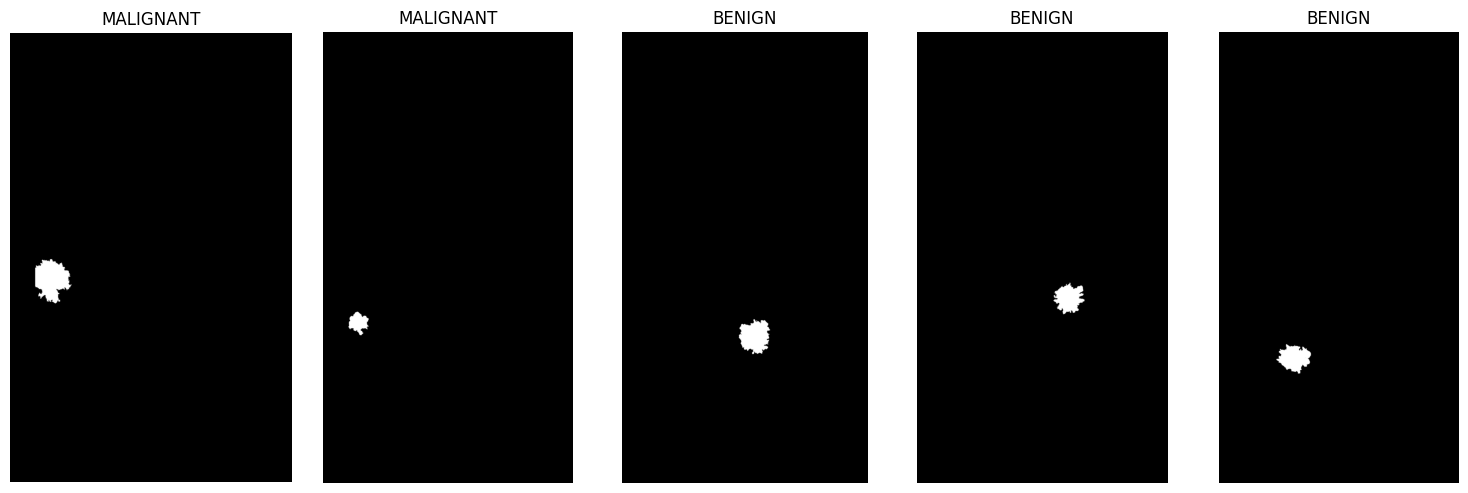

In [24]:
# Mostra imagens do conjunto de dadtos mass_train_data
print('Mass Training Dataset\n\n')
print('Full Mammograms:\n')
display_images('image file path', 5, mass_train_data)
print('Cropped Mammograms:\n')
display_images('cropped image file path', 5, mass_train_data)
print('ROI Images:\n')
display_images('ROI mask file path', 5, mass_train_data)

Calcification Training Dataset


Full Mammograms:

data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/1-188.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727/1-189.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.228699627313487111012474405462022068297/1-190.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.104743410411133110629448544090466900446/1-191.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.406725628213826290127343763811145520834/1-192.jpg


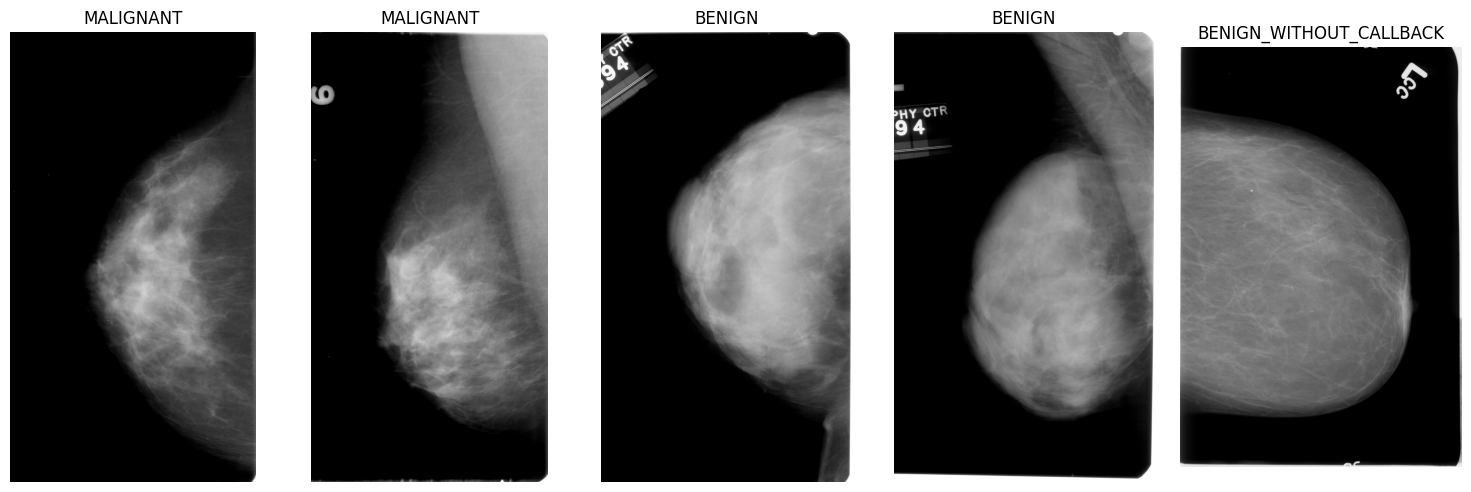

Cropped Mammograms:

data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/2-191.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/1-192.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/1-193.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485/1-194.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495/1-195.jpg


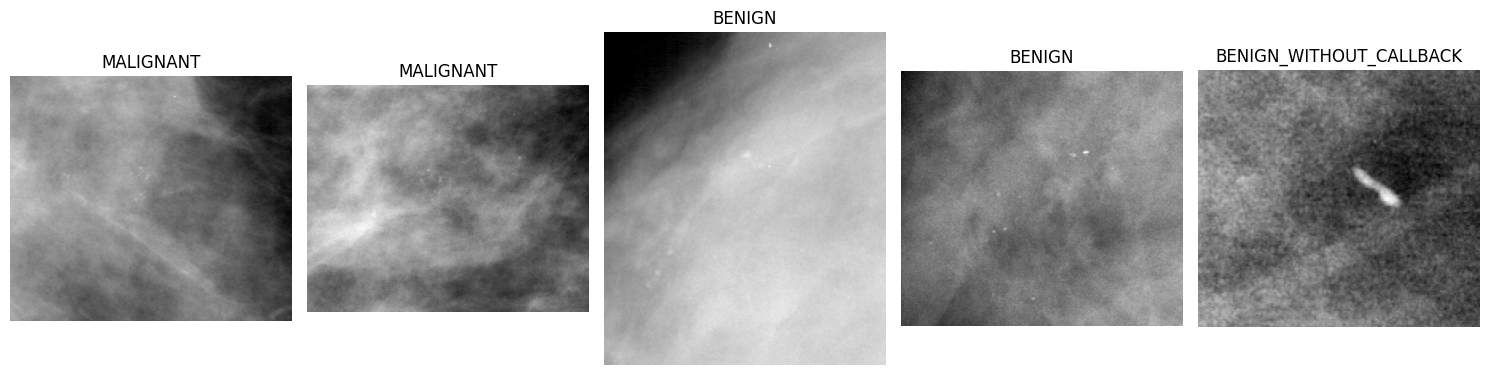

ROI Images:

data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.393344010211719049419601138200355094682/1-107.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/2-108.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.314135871111943890422150247820137952041/2-109.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.91458279612485515203413781822560852485/2-110.jpg
data_CBIS_DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.281397494612871934937455783843630775495/2-111.jpg


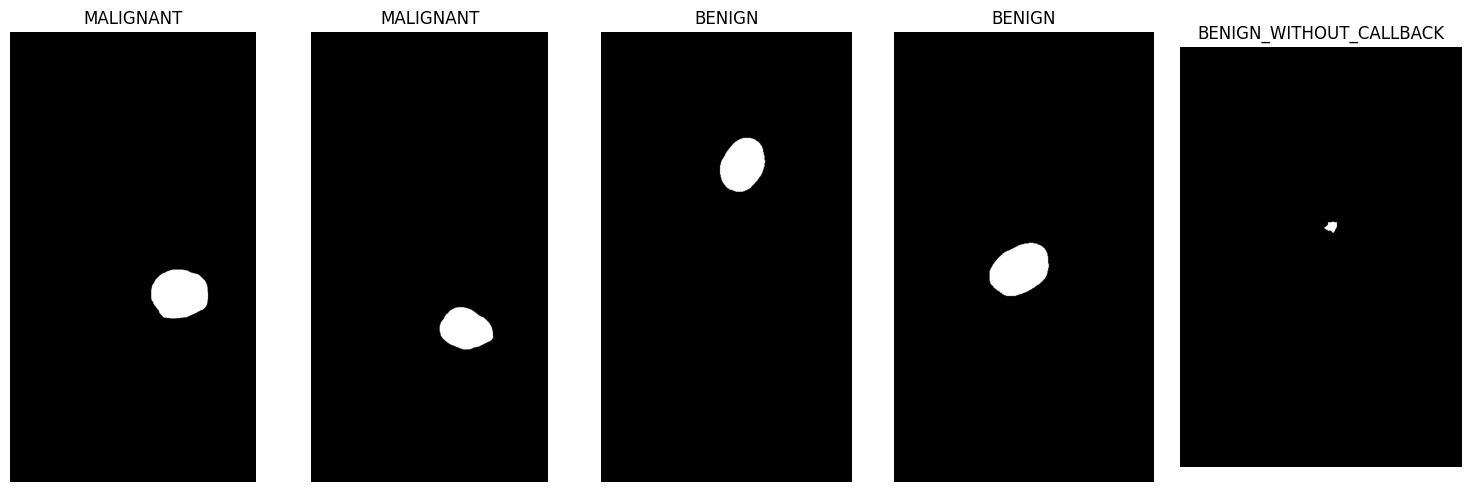

In [25]:
# Mostrar imagens do conjunto de dados calc_train_data
print('Calcification Training Dataset\n\n')
print('Full Mammograms:\n')
display_images('image file path', 5, calc_train_data)
print('Cropped Mammograms:\n')
display_images('cropped image file path', 5, calc_train_data)
print('ROI Images:\n')
display_images('ROI mask file path', 5, calc_train_data)

# Pré-processamento das imagens

Transforma as imagens para o tamanho definido em target_size (224, 224, 3). Isto é necessário pois as imagens tem que ter o mesmo tamanho para serem comparadas.

In [26]:
# Configuração da GPU (executar UMA vez)
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"{len(physical_devices)} GPU(s) configurada(s) com memory growth.")
    except RuntimeError as e:
        print("Erro ao configurar GPU:", e)
else:
    print("Nenhuma GPU encontrada. Usando CPU.")

import tensorflow as tf

def center_crop_to_aspect_ratio(image, target_height, target_width):
    """
    Recorta a imagem centralmente para o aspect ratio desejado.
    image: Tensor (H, W, C)
    """

    shape = tf.shape(image)
    height = shape[0]
    width = shape[1]

    target_ratio = target_width / target_height
    current_ratio = tf.cast(width, tf.float32) / tf.cast(height, tf.float32)

    def crop_width():
        new_width = tf.cast(tf.cast(height, tf.float32) * target_ratio, tf.int32)
        offset = (width - new_width) // 2
        return tf.image.crop_to_bounding_box(
            image, 0, offset, height, new_width
        )

    def crop_height():
        new_height = tf.cast(tf.cast(width, tf.float32) / target_ratio, tf.int32)
        offset = (height - new_height) // 2
        return tf.image.crop_to_bounding_box(
            image, offset, 0, new_height, width
        )

    image = tf.cond(
        current_ratio > target_ratio,
        crop_width,
        crop_height
    )

    return image


def image_processor(image_path, target_size, base_directory="data_CBIS_DDSM/jpeg"):
        
    # Count for skipped and processed images
    skipped_count = 0
    processed_count = 0
    
    # Converte para Path (portável)
    image_path = Path(image_path).resolve()
    base_directory = Path(base_directory).resolve()

    # Verifica se a imagem está dentro do diretório base
    try:
        image_path.relative_to(base_directory)
    except ValueError:
        skipped_count += 1
        return None, skipped_count, processed_count
    
    # Read the image using TensorFlow for GPU acceleration
    image = tf.io.read_file(str(image_path))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Crop para aspect ratio desejado
    image = center_crop_to_aspect_ratio(image, target_size[0], target_size[1])

    # Resize the image sem distorção
    image = tf.image.resize(image, (target_size[0], target_size[1]))

    # Normalize pixel values to be in the range [0, 1]
    image_array = image.numpy()

    processed_count += 1

    return image_array, skipped_count, processed_count

Nenhuma GPU encontrada. Usando CPU.


Aplica o pré-processamento de imagem a cada dataset

In [27]:
# Define target size - Define um tamanho uniforme para as imagens
target_size = (224, 224, 3)

# Apply preprocessor to cropped images in mass_test_data, calc_train_data, and calc_test_data
datasets = [mass_train_data, mass_test_data, calc_train_data, calc_test_data]
dataset_names = ['mass_train_data', 'mass_test_data', 'calc_train_data', 'calc_test_data']

# Create a binary mapping
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

for dataset, name in zip(datasets, dataset_names):
    result = dataset['cropped image file path'].apply(lambda x: pd.Series(image_processor(x, target_size), index=['image_array', 'skipped_count', 'processed_count']))
    dataset[['processed_images', 'skipped_count', 'processed_count']] = result
    dataset['labels'] = dataset['pathology'].replace(class_mapper)
    # Cuidado. O que se faz com dataset após o dataset.dropna não é salvo fora do loop.
    dataset = dataset.dropna(subset=['processed_images'])

    total_skipped = result['skipped_count'].sum()
    total_processed = result['processed_count'].sum()

    print(f"\nProcessing dataset: {name}")
    print(f"Total processed images: {total_processed}")
    print(f"Total skipped images: {total_skipped}")

del datasets, dataset_names, dataset, name, result, total_skipped, total_processed


Processing dataset: mass_train_data
Total processed images: 1318
Total skipped images: 0

Processing dataset: mass_test_data
Total processed images: 378
Total skipped images: 0

Processing dataset: calc_train_data
Total processed images: 1544
Total skipped images: 0

Processing dataset: calc_test_data
Total processed images: 326
Total skipped images: 0


In [28]:
X_mass_train = np.array(mass_train_data['processed_images'].tolist())
y_mass_train = mass_train_data['labels'].values
X_mass_test = np.array(mass_test_data['processed_images'].tolist())
y_mass_test = mass_test_data['labels'].values
X_calc_train = np.array(calc_train_data['processed_images'].tolist())
y_calc_train = calc_train_data['labels'].values
X_calc_test = np.array(calc_test_data['processed_images'].tolist())
y_calc_test = calc_test_data['labels'].values

Visualiza as imagens tratadas

In [ ]:
# Display the first 5 processed images from mass_train_data in a single row of subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    img = mass_train_data['processed_images'].iloc[i]
    axes[i].imshow(img)
    axes[i].set_title(f"Processed Image {i}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Aplicação nos tumores tipo massa

## Cria o modelo CNN

In [30]:
# Realiza data augmentation nas imagens de treino para melhorar a generalização do modelo
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED_setada),
        layers.RandomRotation(0.1, seed=SEED_setada),
        layers.RandomTranslation(0.1, 0.1, seed=SEED_setada),
        layers.RandomZoom(0.1, seed=SEED_setada),
        layers.RandomContrast(0.1, seed=SEED_setada),
    ],
    name="data_augmentation"
)

In [31]:
# Construindo o modelo CNN
kernel_init = tf.keras.initializers.HeNormal(seed=SEED_setada)


model = models.Sequential()
model.add(data_augmentation)

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=target_size, kernel_initializer=kernel_init))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_init))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_init))
model.add(layers.MaxPooling2D((2, 2)))

# Adicionando camadas fully connected
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Compila o modelo
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
        "accuracy"
    ]
)

In [33]:
# Prioziriza a métrica recall_malignant com callbacks
callbacks = [
    EarlyStopping(
        monitor='val_recall',
        patience=10,
        mode='max',
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

# Calcula class weights para lidar com classes desbalanceadas
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_mass_train
)

class_weight = {0: weights[0], 1: weights[1]}
print(class_weight)

# Treinando o modelo
history = model.fit(
    X_mass_train, y_mass_train,
    validation_data=(X_mass_test, y_mass_test),
    epochs=30,
    batch_size=8,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

{0: np.float64(0.9676945668135095), 1: np.float64(1.0345368916797488)}
Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.5076 - loss: 1.3821 - precision: 0.4925 - recall: 0.6170 - val_accuracy: 0.3889 - val_loss: 0.6954 - val_precision: 0.3889 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.4841 - loss: 0.6941 - precision: 0.4812 - recall: 0.8619 - val_accuracy: 0.3889 - val_loss: 0.6945 - val_precision: 0.3883 - val_recall: 0.9932 - learning_rate: 0.0010
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.5061 - loss: 0.6983 - precision: 0.4934 - recall: 0.8242 - val_accuracy: 0.3968 - val_loss: 0.6986 - val_precision: 0.3908 - val_recall: 0.9864 - learning_rate: 0.0010
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.5076 - loss: 0.7026 - precision: 0.4940 - recall: 0.7786 - val_accuracy: 0.3942 - val_loss: 0.6960 - val_precision: 0.3910 - val_recall: 1.0000 - learnin

## Resultados

Evolução durante o treino

In [34]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

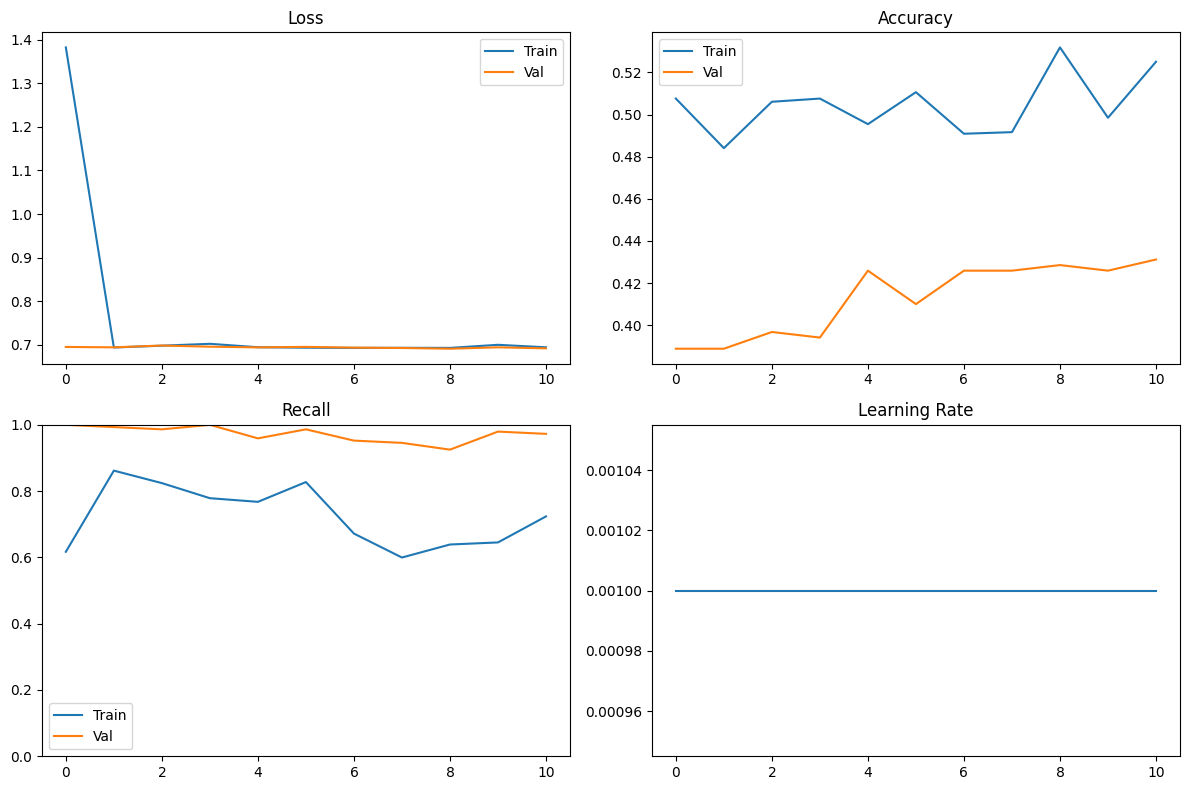

In [35]:
# Compilado compacto da evolução das métricas durante o treinamento
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].plot(history.history['loss'], label='Train')
axs[0,0].plot(history.history['val_loss'], label='Val')
axs[0,0].set_title('Loss')
axs[0,0].legend()

axs[0,1].plot(history.history['accuracy'], label='Train')
axs[0,1].plot(history.history['val_accuracy'], label='Val')
axs[0,1].set_title('Accuracy')
axs[0,1].legend()

axs[1,0].plot(history.history['recall'], label='Train')
axs[1,0].plot(history.history['val_recall'], label='Val')
axs[1,0].set_title('Recall')
axs[1,0].set_ylim(0,1)
axs[1,0].legend()

axs[1,1].plot(history.history['learning_rate'])
axs[1,1].set_title('Learning Rate')

plt.tight_layout()
plt.show()


Resultado final no conjunto de teste

In [36]:
# Verifica as métricas
results = model.evaluate(X_mass_test, y_mass_test, verbose=0, return_dict=True)

for k, v in results.items():
    print(f"{k}: {v:.4f}")

accuracy: 0.3889
loss: 0.6954
precision: 0.3889
recall: 1.0000


In [37]:
# Gera predições no conjunto de teste
y_mass_pred_prob = model.predict(X_mass_test)
y_mass_pred = (y_mass_pred_prob > 0.5).astype(int).ravel()

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step


In [38]:
print(classification_report(
    y_mass_test,
    y_mass_pred,
    target_names=[
        'BENIGN',
        'MALIGNANT'
    ]
))

              precision    recall  f1-score   support

      BENIGN       0.00      0.00      0.00       231
   MALIGNANT       0.39      1.00      0.56       147

    accuracy                           0.39       378
   macro avg       0.19      0.50      0.28       378
weighted avg       0.15      0.39      0.22       378



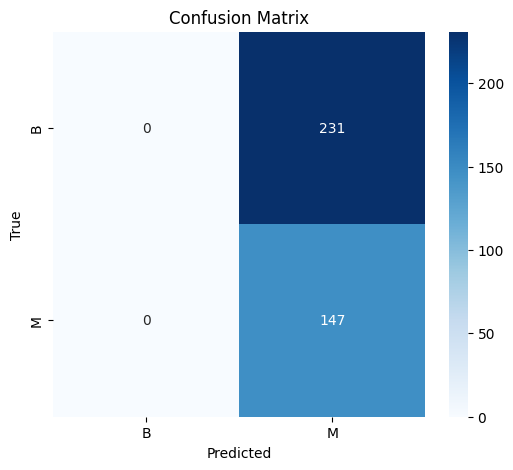

In [39]:
cm = confusion_matrix(y_mass_test, y_mass_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['B', 'M'],
    yticklabels=['B', 'M']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Plota a curva ROC de Maligno vs Benigno + Benigno Without Callback

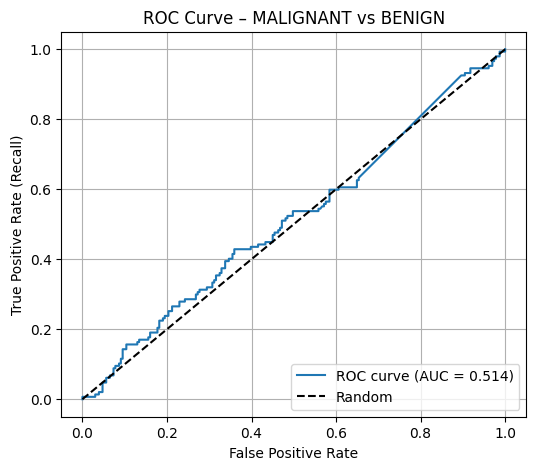

In [40]:
# Classe positiva = MALIGNANT = 1
y_true_bin = y_mass_test.astype(int)

# Probabilidade da classe positiva
# garante shape (N,)
y_score_malignant = y_mass_pred_prob.ravel()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true_bin, y_score_malignant)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve – MALIGNANT vs BENIGN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Discussão dos resultados do modelo aplicado a tumores do tipo massa

A CNN inicialmente implementada apresentou **desempenho insatisfatório**, mesmo após a realização de ajustes em seus hiperparâmetros. Observou-se um comportamento recorrente de **colapso de classes**, no qual o modelo tende a classificar praticamente todas as imagens em uma única categoria. Em algumas execuções, todas as amostras são classificadas como *malignas*, enquanto em outras o modelo passa a classificá-las exclusivamente como *benignas*, evidenciando **instabilidade no processo de aprendizado**.

Esse comportamento sugere que a topologia adotada para a CNN não foi capaz de extrair características discriminativas suficientes para separar adequadamente as classes de interesse. Embora seja possível tentar diferentes arquiteturas e combinações de camadas na busca por maior estabilidade, tal abordagem mostrou-se pouco eficiente no contexto deste trabalho.

Diante da dificuldade em obter uma topologia de CNN convencional que apresentasse resultados consistentes e robustos, optou-se pela utilização da **EfficientNet**, uma família de redes neurais convolucionais desenvolvida pelo Google. Essa arquitetura é amplamente reconhecida por sua eficiência no uso de parâmetros e por apresentar melhor capacidade de generalização, especialmente em cenários com conjuntos de dados limitados, como é o caso deste estudo.


## Efficient Net

In [41]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=target_size
    )

# Congela a EfficientNet
base_model.trainable = False

In [42]:
model = models.Sequential([
    data_augmentation,            # só no treino
    base_model,                   # extrator de features
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")  # binário
])

In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.Precision(name="precision"),
        "accuracy"
    ]
)

In [44]:
history = model.fit(
    X_mass_train, y_mass_train,
    validation_data=(X_mass_test, y_mass_test),
    epochs=30,
    batch_size=16,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 25s 188ms/step - accuracy: 0.4932 - loss: 0.9614 - precision: 0.4762 - recall: 0.4867 - val_accuracy: 0.6111 - val_loss: 0.6715 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.4962 - loss: 0.8887 - precision: 0.4801 - recall: 0.5118 - val_accuracy: 0.3889 - val_loss: 0.7060 - val_precision: 0.3889 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.4803 - loss: 0.8479 - precision: 0.4647 - recall: 0.4961 - val_accuracy: 0.6111 - val_loss: 0.6920 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 155ms/step - accuracy: 0.5038 - loss: 0.8039 - precision: 0.4872 - recall: 0.5071 - val_accuracy: 0.3915 - val_loss: 0.6936 - val_precision: 0.3881 - val_recall: 0.9796 - learning_rate: 0.0010
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 15

accuracy: 0.6111
loss: 0.6715
precision: 0.0000
recall: 0.0000
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step
              precision    recall  f1-score   support

      BENIGN       0.61      1.00      0.76       231
   MALIGNANT       0.00      0.00      0.00       147

    accuracy                           0.61       378
   macro avg       0.31      0.50      0.38       378
weighted avg       0.37      0.61      0.46       378



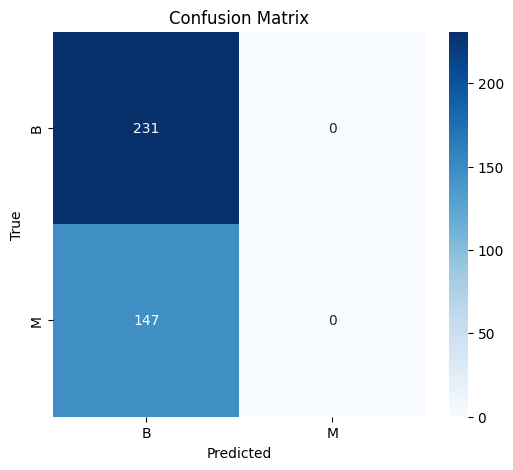

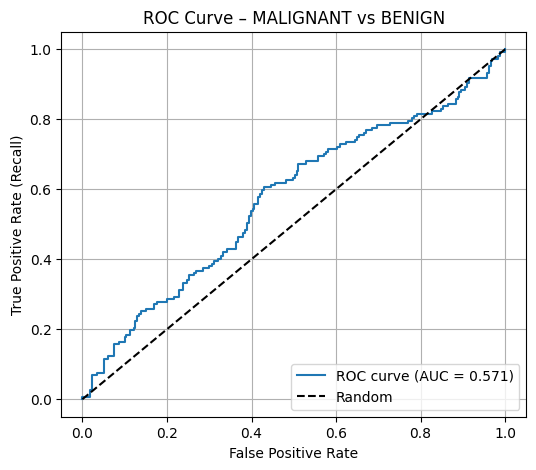

In [45]:
# Verifica as métricas
results = model.evaluate(X_mass_test, y_mass_test, verbose=0, return_dict=True)

for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Gera predições no conjunto de teste
y_mass_pred_prob = model.predict(X_mass_test)
y_mass_pred = (y_mass_pred_prob > 0.5).astype(int).ravel()


print(classification_report(
    y_mass_test,
    y_mass_pred,
    target_names=[
        'BENIGN',
        'MALIGNANT'
    ]
))

cm = confusion_matrix(y_mass_test, y_mass_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['B', 'M'],
    yticklabels=['B', 'M']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classe positiva = MALIGNANT = 1
y_true_bin = y_mass_test.astype(int)

# Probabilidade da classe positiva
# garante shape (N,)
y_score_malignant = y_mass_pred_prob.ravel()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true_bin, y_score_malignant)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve – MALIGNANT vs BENIGN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Discussão dos resultados da EfficientNet aplicada a tumores do tipo massa

A aplicação da EfficientNet aos tumores do tipo massa apresentou um comportamento semelhante ao observado com a CNN convencional. O modelo demonstrou **tendência ao colapso de classes**, passando a classificar a maioria — ou a totalidade — das imagens em uma única categoria. Em diferentes execuções, esse viés alternou-se entre a classificação de todas as amostras como *malignas* ou exclusivamente como *benignas*, indicando **instabilidade no processo de aprendizado**, mesmo com o uso de uma arquitetura mais avançada.

Embora possa ser realizados ajustes no limiar de decisão (*decision threshold*), a análise da curva ROC evidencia que o modelo apresenta **baixa capacidade discriminativa**. O valor de **AUC igual a 0,57** aproxima-se do desempenho aleatório, sugerindo que a EfficientNet, nas condições avaliadas, não conseguiu extrair informações suficientes das imagens para diferenciar adequadamente entre lesões benignas e malignas.

Esses resultados indicam que, apesar das vantagens da EfficientNet em termos de eficiência e generalização, fatores como a natureza dos dados, o nível de ruído presente nas imagens e a similaridade visual entre as classes podem limitar significativamente o desempenho do modelo nesse cenário específico.


# Aplicando nos tumores tipo calcificação

Será utilizada a mesma topologia de CNN para os tumores tipo calcificação

In [46]:
# Treinando o modelo
history = model.fit(
    X_calc_train, y_calc_train,
    validation_data=(X_calc_test, y_calc_test),
    epochs=30,
    batch_size=8,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.5583 - loss: 0.7956 - precision: 0.3596 - recall: 0.3278 - val_accuracy: 0.6043 - val_loss: 0.6746 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.7000e-05
Epoch 2/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.5777 - loss: 0.7641 - precision: 0.3570 - recall: 0.2505 - val_accuracy: 0.6043 - val_loss: 0.6814 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.7000e-05
Epoch 3/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.5777 - loss: 0.7449 - precision: 0.3353 - recall: 0.2044 - val_accuracy: 0.6043 - val_loss: 0.6803 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 2.7000e-05
Epoch 4/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.5913 - loss: 0.7290 - precision: 0.3493 - recall: 0.1878 - val_accuracy: 0.6043 - val_loss: 0.6805 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 8.1000e-06
Epoc

accuracy: 0.6043
loss: 0.6746
precision: 0.0000
recall: 0.0000
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step
              precision    recall  f1-score   support

      BENIGN       0.60      1.00      0.75       197
   MALIGNANT       0.00      0.00      0.00       129

    accuracy                           0.60       326
   macro avg       0.30      0.50      0.38       326
weighted avg       0.37      0.60      0.46       326



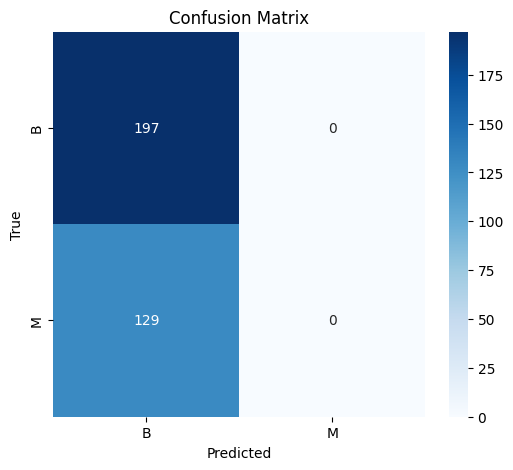

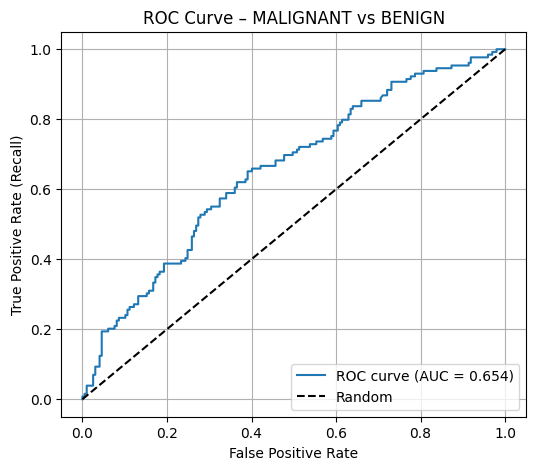

In [47]:
# Verifica as métricas
results = model.evaluate(X_calc_test, y_calc_test, verbose=0, return_dict=True)

for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Gera predições no conjunto de teste
y_calc_pred_prob = model.predict(X_calc_test)
y_calc_pred = (y_calc_pred_prob > 0.5).astype(int).ravel()


print(classification_report(
    y_calc_test,
    y_calc_pred,
    target_names=[
        'BENIGN',
        'MALIGNANT'
    ]
))

cm = confusion_matrix(y_calc_test, y_calc_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['B', 'M'],
    yticklabels=['B', 'M']
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classe positiva = MALIGNANT = 1
y_true_bin = y_calc_test.astype(int)

# Probabilidade da classe positiva
# garante shape (N,)
y_score_malignant = y_calc_pred_prob.ravel()
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true_bin, y_score_malignant)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve – MALIGNANT vs BENIGN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Discussão dos resultados da CNN aplicada a tumores do tipo calcificação

A aplicação da CNN aos tumores do tipo calcificação apresentou **comportamento semelhante ao observado nos experimentos com tumores do tipo massa**. O modelo demonstrou dificuldade em aprender padrões discriminativos relevantes, resultando novamente em **instabilidade no processo de classificação** e tendência ao colapso para uma única classe.


# Conclusão

A utilização de redes neurais convolucionais (CNNs) para o diagnóstico a partir de imagens médicas segue o fluxo metodológico apresentado neste notebook. No entanto, a obtenção de um modelo com desempenho adequado exige um processo cuidadoso e sistemático de experimentação, envolvendo a variação de múltiplos fatores, tais como o tamanho das imagens de entrada (*target size*), a topologia da rede, as estratégias de pré-processamento, bem como os hiperparâmetros de treinamento.

Nesta primeira abordagem, apesar das diferentes tentativas realizadas, não foi possível alcançar métricas consideradas satisfatórias ou clinicamente úteis. Os modelos avaliados apresentaram instabilidade no aprendizado e baixa capacidade discriminativa, o que compromete sua aplicabilidade prática.

Diante do contexto médico, em que erros de classificação podem ter consequências significativas, os resultados obtidos reforçam a necessidade de investigações adicionais, incluindo o uso de arquiteturas mais especializadas, estratégias avançadas de balanceamento de classes, refinamento do pré-processamento e, possivelmente, a incorporação de informações clínicas complementares às imagens.